In [1]:
%load_ext autoreload
%autoreload 2

To check :

If I initialize on a bathymetric point, will parcels throw an error or just ignore. This will affect how I specify the initialization.

In [2]:
import xarray as xr
import pandas as pd
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
import os
from datetime import timedelta
import copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [3]:
import bsose.preprocess as pp

In [4]:
ds,xgrid = pp.load_bsose()

In [29]:
N = 50
lonV = 291-10
latV = [-75, -55]
depthV = [-3000,-200]

lats1D = np.linspace(latV[0],latV[1],N)
lons1D = np.arange(231,291,10)
depths1D = np.linspace(depthV[0],depthV[1],N)

[lons,lats,depths] = np.meshgrid(lons1D,lats1D,depths1D)

### Map projection

In [30]:
varstr = "THETA"
iselect = {"time":-1}
select = {"Z":depthV[1]}
da = ds["THETA"].isel(
    **iselect).sel(
    **select,method='nearest')
da_masked = np.ma.masked_where(da==0,da)

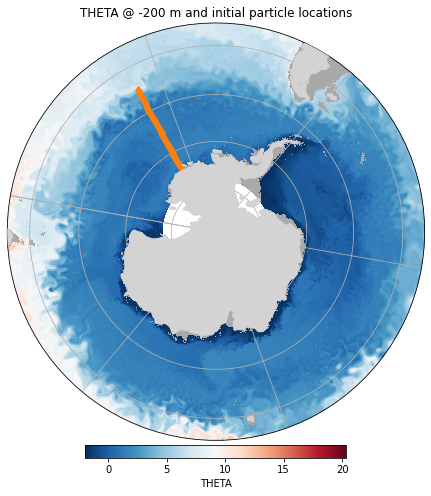

In [31]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('darkgray')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

im=ax.pcolormesh(ds["XC"],ds["YC"],da_masked,cmap=cmap,
              transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax,
             orientation='horizontal',
            fraction=0.03,pad=0.01,
            label=varstr)

ax.plot(lons[:,0,0],
        lats[:,0,0],
        linestyle='None',
        marker='d',
        color='tab:orange',
        transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
ax.gridlines()
ax.set_title(
    varstr+(' @ %s m'%depthV[1])+' and initial particle locations');

### Depth distribution

In [25]:
iselect = {"time":-1}
selectslice = {"YC":slice(latV[0]-5,latV[1]+5)}
select = {"XC":lonV}
da = ds[varstr].isel(
    **iselect).sel(
    **select,method='nearest').sel(
    **selectslice)
da_masked = np.ma.masked_where(da==0,da)

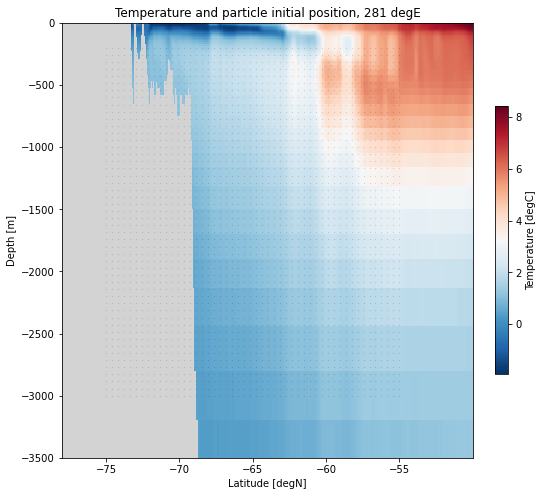

In [26]:
fig,ax = plt.subplots(figsize=(8,8))
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('lightgray')
im = ax.pcolormesh(da['YC'],da['Z'],da_masked,shading='auto',cmap=cmap)
ax.plot(lats.flatten(),
        depths.flatten(),
        linestyle='None',
        marker='.',
        color='k',
        markersize=0.1)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degN]')
ax.set_title('Temperature and particle initial position, %s degE' %str(lonV))
ax.set_ylim([depthV[0]-500,0])
plt.colorbar(im,ax=ax,
             fraction=0.03,pad=0.05,
             label='Temperature [degC]')

In [33]:
inits = da.interp({"YC":lats1D,"Z":depths1D})
lonnow = inits.copy(data = )
inits == 0

<xarray.DataArray 'THETA' (Z: 50, YC: 50)>
dask.array<eq, shape=(50, 50), dtype=bool, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 2018-12-30
    XC       float32 290.9167
    Depth    (YC) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    rA       (YC) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF      (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    hFacC    (Z, YC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * YC       (YC) float64 -65.0 -64.81 -64.61 -64.42 ... -55.89 -55.69 -55.5
  * Z        (Z) float64 -2.5e+03 -2.455e+03 -2.41e+03 ... -389.8 -344.9 -300.0

In [16]:
ds["XC"]

<xarray.DataArray 'XC' (XC: 2160)>
array([8.333334e-02, 2.500000e-01, 4.166667e-01, ..., 3.595833e+02,
       3.597500e+02, 3.599167e+02], dtype=float32)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    coordinate:     YC XC
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
    axis:           X

In [28]:
np.arange(231,291,10)

array([231, 241, 251, 261, 271, 281])